# Timeseries Forecasting Sample

In this notebook, you'll see examples of how to:

- define structured schemas by using `NamedTuple`, also with containers and nested named tuples as members
- create a data source as a composite
- insert window punctuations into a stream by using a callable
- aggregate data within a tumbling punctuation based window
- use the [`Stream.flat_map`](https://streamsxtopology.readthedocs.io/en/stable/streamsx.topology.topology.html#streamsx.topology.topology.Stream.flat_map) function to create additional tuples
- invoke an SPL operator

Familiarity with [Python](https://www.python.org/about/gettingstarted/) is highly recommended.

If you are new to the  Streams Python API, [start with this tutorial](https://github.com/IBMStreams/sample.starter_notebooks/blob/latest/Streams-RollingAverageSample.ipynb).

The notebook is divided into following sections, from which _Create the application_ is the most extensive one.

 1. [Setup your Streams instance](#setup)
 1. [Create the application](#create)
 1. [Submit the application](#launch)
 1. [Connect to the running application to view data](#view)
 1. [Stop the application](#cancel)

# Overview

**About the sample**

This sample simulates a call center, which creates an event when a call is terminated. For simplicity, these records contain only following data: 

- the call center agent
- the timestamp when the call has been terminated
- the duration of the call

The duration of the calls as well as the time between two calls is randomly distributed and follows a log-normal distribution. During the night hours and at weekends, the calls shall happen less frequently, so that the call termination events form an _irregular complex seasonal timeseries_. The timeseries is irregular as the events are not equally spaced in time. The data has two seasons: The inner season is a day, while the outer season is a week.

These call events are aggregated for every hour, in such a ways that we get one sampling point for every hour. We are only interested in the hourly call volume, i.e. the sum of the durations of all calls. For hours, in which we see no activity in the call center, the hourly aggregates are missing. To create a _regular timeseries_, i.e. at equally spaced points in time, we create artificial aggregates. Here we use the [`Stream.flat_map`](https://streamsxtopology.readthedocs.io/en/stable/streamsx.topology.topology.html#streamsx.topology.topology.Stream.flat_map) function with a suitable callable class.

Finally, we use the [`BATS`](https://www.ibm.com/support/knowledgecenter/SSCRJU_5.5/com.ibm.streams.toolkits.doc/toolkits/dita/tk$com.ibm.streams.timeseries/op$com.ibm.streams.timeseries.modeling$BATS.html) SPL operator from the timeseries toolkit to forecast the hourly call volumes for the next hours. The outcome of the forecast operator is visualized in a chart with [matplotlib](https://matplotlib.org/).

The data generation can be speeded up to make the timestamps increase significantly faster than realtime. The default value in this notebook is 7200, defined in variable `time_compression`. 

**How it works**
   
The Python application created in this notebook is submitted to the IBM Streams service for execution.

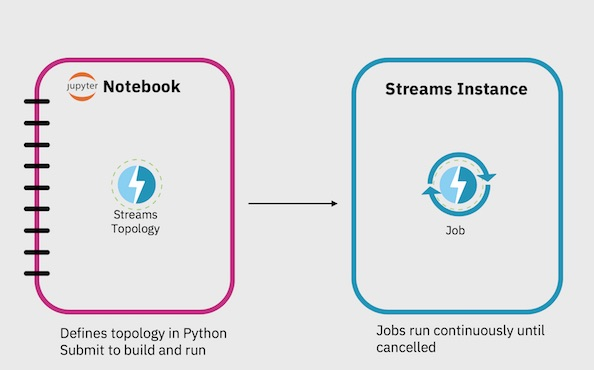


## Documentation
    
- [Streams Python development guide](https://ibmstreams.github.io/streamsx.documentation/docs/latest/python/)
- [Streams Python API](https://streamsxtopology.readthedocs.io/)



# Prerequisites

This notebook can be used as-is from within an IBM Cloud Pak for Data project and with a local Streams installation.
To use this notebook, you must install `matplotlib` within your Python environment, for example:

    pip install matplotlib

If you are not running this notebook from within IBM Cloud Pak for Data, [follow these steps to make sure you have installed all the prerequisites](https://ibmstreams.github.io/streamsx.documentation/docs/python/1.6/python-appapi-devguide-2/).

<a name="setup"></a>


# 1. Set up a connection to the Streams instance


To submit the application for execution, you have to connect to the Streams instance. The information required to connect to the instance depends on the target installation of Streams. 

Choose the option that matches your development environment.

- **Option 1**: [I'm running the notebook from an IBM Cloud for Data project](#cpd)
- **Option 2**: [I'm using IBM Watson Studio, Jupyter Notebooks, or any other development environment](#notcpd)



In [ ]:
try:
    import matplotlib.pyplot as plt
except ImportError:
    print("Please install matplotlib into your Python environment")
    raise

<a name="cpd"></a>
### Option 1: Connect to a Streams instance from an IBM Cloud Pak for Data  project

In order to submit a Streams application you need to provide the name of the Streams instance.

1. From the navigation menu, click **Services > Instances**.
2. Update the value of `streams_instance_name` in the cell below according to your Streams instance name
3. Run the cell and skip to section 1.2

The cell below defines a function called `submit_topology` that will be used later on to submit the `Topology` once it is defined.



In [ ]:
from streamsx.topology import context

streams_instance_name = "pzo-tools" ## Change this to Streams instance
try:
    from icpd_core import icpd_util
    cfg = icpd_util.get_service_instance_details(name=streams_instance_name, instance_type="streams")
except TypeError:
    cfg = icpd_util.get_service_instance_details(name=streams_instance_name)
except ImportError:
    # not within a Cloud Pak for Data project
    cfg = dict()

def submit_topology(topo, context_type=context.ContextTypes.DISTRIBUTED):
    global cfg
    # Disable SSL certificate verification if necessary
    cfg[context.ConfigParams.SSL_VERIFY] = False
    return context.submit (context_type, topo, config=cfg)

print("Setup complete, continue to section 1.2")

<a name="notcpd"></a>
### Option 2: Connect to a Streams instance from IBM Watson Studio and other environments

*Skip this section if you are running the notebook from a Cloud Pak for Data project.*

The code for each scenario is available in the development guide.  
Each snippet will define a function called `submit_topology` that will be used later on to submit the `Topology` once it is defined.

- Choose the tab that best matches your environment. 
- Copy the code under the heading **Copy this code snippet**.
- Paste it in the cell below.

    [Connection instructions from the development guide](https://ibmstreams.github.io/streamsx.documentation/docs/python/1.6/python-appapi-devguide-2/#connect)


In [ ]:
## Paste snippet from development guide


### 1.2 Import  the `streamsx` package and verify the package version
We need at least version 1.16 of the streamsx package.

In [ ]:
import streamsx.topology.context
version = streamsx.topology.context.__version__
v = version.split('.')
vv = int(v[0] + v[1])

print("INFO: streamsx package version: " + version)

if vv < 116:
    raise ValueError ("streamsx version too low. Please upgrade streamsx to at least version 1.16")

#For more details uncomment line below.
#!pip show streamsx

<a name="create"></a>
# 2. Create the application
Creating an application means to define schemas, callables, and finally a `Topology`, which is basically a data structure that defines the streaming application. We are going to define the schemas and callables when they are needed to define a stream or transform.

## 2.1 Define the schema for the data source
The data source creates a stream of tuples with structured data with three attributes: 


In [ ]:
import typing

# schema of the source stream
class CallTerminationEventSchema(typing.NamedTuple):
    callcenter_agent: str
    call_termination_time: float  # seconds since Epoch
    call_duration_secs: float


## 2.2 Define a callable to punctuate the source stream
Punctuations, or window markers, are signals within the stream. They flow together with the data tuples through the application. The meaning of these signals fully depends on the application design. In this application, a window marker separates the data according the full hour of their timestamps. Whenever the hour of the timestamp of two sequential tuples changes, a window marker is to be inserted.

The callable below returns `True`, when the hour of the call termination timestamp is higher than the previous one, `False` otherwise. A callable for the [`Stream.punctor`](https://streamsxtopology.readthedocs.io/en/stable/streamsx.topology.topology.html#streamsx.topology.topology.Stream.punctor) function must return a boolean value.

We will use this callable class when we define the source of our data.

In [ ]:
# Callable to punctuate the source stream
class TimeStampHourChanged:
    def __init__(self):
        self.previous = None

    def __call__(self, call_termination: CallTerminationEventSchema):
        if self.previous is None:
            self.previous = call_termination
            return False
        prev_hour = self.previous.call_termination_time//3600
        this_hour = call_termination.call_termination_time//3600
        self.previous = call_termination
        if this_hour > prev_hour:
            return True
        return False


## 2.3 Define a data source as a composite
[Composite transforms](https://streamsxtopology.readthedocs.io/en/stable/streamsx.topology.composite.html#module-streamsx.topology.composite) encapsulate multiple stream transforms in a single class and can be used as . In this notebook we will define a [Source](https://streamsxtopology.readthedocs.io/en/stable/streamsx.topology.composite.html#streamsx.topology.composite.Source) that emits a punctuated stream. The subgraph in our composite consists of the actual source followed by a punctuation inserter pseudo transform.

As we create a _source composite_, we derive our class from `streamsx.topology.composite.Source`. The transforms of the source must be implemented in the overwritten `populate` method. This method must return a `Stream` object:

In [ ]:
from streamsx.topology.composite import Source
from datetime import datetime
import time
import random

class CallsSeasonal(Source):
    def __init__(self, speedup = 3600.0, n_tuples_no_delay = 0):
        self.starttime = datetime.now().timestamp()  # seconds since Epoch as float
        self.speedup = speedup                       # time scaling compared with a wall clock
        self.n_no_delay = n_tuples_no_delay
        
    # generator method
    def create_call_terminations(self) -> typing.Iterable[CallTerminationEventSchema]:
        next_timestamp = self.starttime;
        delta_t = 0.0
        i = 0
        while True:
            if i > self.n_no_delay:
                time.sleep(delta_t/self.speedup)
            i += 1
            
            # we assume that call durations are distributed according a log-normal distribution
            # and do not depend on week day and hour of day
            duration = random.lognormvariate(0, 0.7) * 120
            ct = CallTerminationEventSchema("Superagent", next_timestamp, duration)

            # distance to next call termination
            # decompose the timestamp into hour and weekday, so that we can model seasonal data
            dt = datetime.fromtimestamp(next_timestamp)
            weekday = dt.isoweekday()  # Monday = 1, Sunday = 7
            hour = dt.hour             # 0..23

            # the time difference between the call terminations shall depend on hour and weekday
            # and follows also a lognormal distribution, which we scale dependent on hour and day.
            if weekday in [6, 7]:  # Sat, Sun
                w = 3
            else:
                w = 1
            if hour in [0, 1, 2, 3, 4]:
                h = 600
            elif hour in [5, 23]:
                h = 300
            elif hour in [6, 7, 22]:
                h = 90
            else:
                h = 30
            delta_t = random.lognormvariate(0, 1) * h * w
            next_timestamp += delta_t
            yield (ct)

    # define the subgraph; here we have a source followed by a punctuation inserter
    def populate(self, topology, name, **options) -> streamsx.topology.topology.Stream:
        if name is None:
            name = 'Calls'
        
        call_terminations = topology.source(self.create_call_terminations, name=name + '_gen')
        # insert a window marker when the hour of the timestamp has changed, before the new hour
        # The callable class will keep the previous tuple for detecting the change
        return call_terminations.punctor(TimeStampHourChanged(), before=True, replace=False, name=name + '_punct_insert')


## 2.4 Define the topology and add the source

In [ ]:
from streamsx.topology.topology import Topology

# time stamps grow 7200 times faster than in realtime. With 7200, one hour elapses in 0.5 seconds
time_compression = 7200

topo = Topology(name="CallcenterWorkloadForecast", namespace="sample")
source_composite = CallsSeasonal(speedup=time_compression, n_tuples_no_delay=14*24*38)
terminated_calls = topo.source(source_composite, name="CallGenerator")


## 2.5 Aggregate the call termination events for every hour
The `terminated_calls` stream contains window markers such that onyl data from one hour are delimited by window markers. For the outcome of the aggregation, we define the new schema `CallAggregateSchema`. The actual aggregation is performed by the callable class `CallDurationSum`, to which an `Iterable` with the tuples within the window is passed. The schema of the transformed stream is derived from the type hint of the `__call__` function. The punctuation based tumbling window is defined by [`Stream.batch('punct')`](https://streamsxtopology.readthedocs.io/en/stable/streamsx.topology.topology.html#streamsx.topology.topology.Stream.batch).

In [ ]:
# Schema definition
class CallAggregateSchema(typing.NamedTuple):
    num_calls: int = 0
    n_distinct_callcenter_agents: int = 0
    sample_timestamp: int = 0
    aggregated_call_duration: float = 0.0
    min_call_duration: float = 0
    max_call_duration: float = 0

# Aggregation Callable
class CallDurationSum:
    def __call__(self, window_content) -> CallAggregateSchema:
        distinct_agents = set()
        min = 0.0
        max = 0.0
        sum = 0.0
        for tuple in window_content:
            if tuple.call_duration_secs > max:
                max = tuple.call_duration_secs
            if min == 0.0 or tuple.call_duration_secs < min:
                min = tuple.call_duration_secs
            sum += tuple.call_duration_secs
            distinct_agents.add(tuple.callcenter_agent)
        # calculate the sample timestamp. The sample timestamp is the timestamp of 
        # the last item in the window aligned to the next full hour, for example, if the
        # items in the window have timestamps 09:03:45, 09:45:34, the sample timestamp 
        # of the aggregate will be 10:00:00.
        agg_sample_time = 0
        if len(window_content) > 0:
            div = int(window_content[-1].call_termination_time) // 3600
            mod = int(window_content[-1].call_termination_time) % 3600
            if (mod == 0):
                agg_sample_time = div * 3600
            else:
                agg_sample_time = (div + 1) * 3600
        
        return CallAggregateSchema(len(window_content), len(distinct_agents), agg_sample_time, sum, min, max)

# define a window that contains the data between two window markers, and aggregate these data
hourly_call_volumes = terminated_calls.batch('punct').aggregate(CallDurationSum())


## 2.6 Regularize the time series
During night hours, the simulated call center can be idle. For these hours, the aggration does not create tuples as the window marker separates time periods, in which the hour differs by more than one. To have a regular time series with equally spaced timestamps, we create artificial tuples, in which all the data is zero. We can use the [`Stream.flat_map`](https://streamsxtopology.readthedocs.io/en/stable/streamsx.topology.topology.html#streamsx.topology.topology.Stream.flat_map) transform to create addional tuples.

The callable returns an `Iterable`, that contains the potentially missing tuples and the current tuple. The `flat_map` transfrom emits a tuple for each item in the Iterable returned by `__call__`. The schema of the transformed stream is derived from the type hint.

In [ ]:
# create missing sample points for hours, in which no call happened. We create a flat_map callable that
# creates an Iterable, which contains missing tuples + current tuple
class Regularize:
    def __init__(self):
        self.previous = None

    def __call__(self, tupl: CallAggregateSchema) -> typing.Iterable[CallAggregateSchema]:
        if self.previous is None:
            self.previous = tupl
            return [tupl]
        
        next_sample_time = self.previous.sample_timestamp + 3600
        timestamp_diff = tupl.sample_timestamp - next_sample_time
        
        result = []
        while timestamp_diff > 0:
            # add artificial equally spaced sample points
            result.append(CallAggregateSchema(0, 0, next_sample_time, 0.0, 0.0, 0.0))
            timestamp_diff -= 3600
            next_sample_time += 3600
        # finally add the received tuple
        result.append(tupl)
        self.previous = tupl
        return result

hourly_call_volumes_regularized = hourly_call_volumes.flat_map(Regularize())

## 2.7 Invoke an SPL forecasting operator
To forecast the hourly call volume for the next hours, we use the [BATS operator](https://www.ibm.com/support/knowledgecenter/SSCRJU_5.5/com.ibm.streams.toolkits.doc/toolkits/dita/tk$com.ibm.streams.timeseries/op$com.ibm.streams.timeseries.modeling$BATS.html) from the timeseries toolkit. The schema of the stream is defined by the NamedTuple `Prediction`. As a speciality we have here
- a list of primitive types (`predicted_values` attribute)
- a list of another structured type (`prediction_intervals` attribute)


In [ ]:
import streamsx.spl.op as op

# The BATS operator specifies the structure of a prediction interval.
# The prediction interval MUST have the attributes 'lower' and 'upper' as float in this sequence. 
class PredictionInterval(typing.NamedTuple):
    lower: float
    upper: float

# outgoing schema of the BATS operator
class Prediction(typing.NamedTuple):
    sample_timestamp: int
    aggregated_call_duration: float
    predicted_values: typing.List[float]
    prediction_intervals: typing.List[PredictionInterval]

# invoke the operator com.ibm.streams.timeseries.modeling::BATS
from streamsx.spl.types import uint64

bats_invoke = op.Invoke(topo,
                        inputs = hourly_call_volumes_regularized,
                        kind = "com.ibm.streams.timeseries.modeling::BATS",
                        schemas = Prediction,
                        params = {'initSamples': 14 * 24,  # 14 days * 24 hours
                                  'stepAhead': 8,          # predict up to next 8 hours
                                  'confidenceLevel': 0.9,
                                  'useBoxCox': False,      # cannot be used with zero values
                                  'forecastedAllTimeseriesSteps': 'predicted_values',
                                  'allConfidenceIntervals': 'prediction_intervals'}
                       )

# parameter, that references an attribute of the input stream:
bats_invoke.params['inputTimeSeries'] = bats_invoke.attribute(hourly_call_volumes_regularized,
                                                              'aggregated_call_duration')

# output stream:
hourly_forecasts = bats_invoke.outputs[0]

# Create a view on this stream for data visualization:
forecast_view = hourly_forecasts.view(name="ForecastedData", description="hourly forecasts")

# Terminate stream by publishing the data to be picked up by another streaming application in this service instance.
# Other Stream terminations like publishing to Kafka, writing into data bases, or whatever are possible, of course.
hourly_forecasts.publish(topic='callcenter/hourlyforcasts')


<a name="launch"></a>
# 3. Submit the application
A running Streams application is called a *job*. By submitting the topology we create a job.

In [ ]:
submission_result = submit_topology(topo)
if submission_result.job:
    streams_job = submission_result.job
    print("Job-ID: ", streams_job.id , "\nJob name: ", streams_job.name)
else:
    print("Submission failed: "   + str(submission_result))

<a name="view"></a>
# 4. Visualize the data from the job with `matplotlib`
Now that the job is started, use the `View` object to start retrieving data from a `Stream`. We will be using the view object `forecast_view`, which we have created from the `hourly_forecasts` stream.
The forecasting operator will suppress initial input tuples to calculate the BATS algorithm parameters from. Therefore it takes some time until the first data is visualized.

In [ ]:
import matplotlib.pyplot as plt

plot_window = 120
def create_plot(timeticks, current_vals, next_forecasts, forecasts_lower, forecasts_upper):
    figure, axes = plt.subplots(figsize=(10, 5), dpi=96)
    plt.title('Actual and forecasted hourly call volumes')
    axes.set_xlabel('timeticks [hour]')
    axes.set_ylabel('hourly call volume [seconds]')
    axes.grid(True, axis='both') # axis = {x,y,both}
    axes.plot(timeticks, current_vals, linewidth=3, label='actual data')
    axes.plot(timeticks, next_forecasts, linewidth=1, label='next hour forecast')
    axes.plot(timeticks, forecasts_lower, linewidth=1, linestyle='dashed', label='forecast interval lower')
    axes.plot(timeticks, forecasts_upper, linewidth=1, linestyle='dashed', label='forecast interval upper')
    axes.set_xlim(0, plot_window)
    axes.set_ylim(-2000, 20000)
    plt.legend(loc='upper center', ncol=4, borderaxespad=0.0, fontsize='small')
    return figure, axes

**Be patient, the BATS forecasting algorithm is being trained. It can take some minutes until data is visualized.**

%matplotlib notebook

from collections import deque
from queue import Empty
n_tuples_to_visualize = 360
next_forecast = 1     # 1..8 forecast horizon = next 1 hour

timeticks = deque(maxlen=plot_window)
aggregated_call_durations = deque(maxlen=plot_window)
next_forecasts = deque(maxlen=plot_window)
forecasts_lower = deque(maxlen=plot_window)
forecasts_upper = deque(maxlen=plot_window)
figure, axes = create_plot([], [], [], [], [])

try:
    tuple_queue = forecast_view.start_data_fetch()
    timetick_offset = -1
    i = 0
    timeouts = 0
    batch = []
    while (i < n_tuples_to_visualize) and (timeouts < 360):
        # visualize the data from the view in batches as we want the figure not be drawn too frequently
        batch.clear()
        while len(batch) < max(1, time_compression/3600):
            try:
                tuple = tuple_queue.get(timeout=1)
                batch.append(tuple)                
                timeouts = 0
                i += 1
            except Empty:
                timeouts += 1
                break
        
        if len(batch) > 0:
            for tuple in batch:
                if timetick_offset == -1:
                    timetick_offset = tuple['sample_timestamp']
                timeticks.append((tuple['sample_timestamp'] - timetick_offset)/3600)
                aggregated_call_durations.append(tuple['aggregated_call_duration'])
                next_forecasts.append(tuple['predicted_values'][next_forecast-1])
                forecasts_lower.append(tuple['prediction_intervals'][next_forecast-1]['lower'])
                forecasts_upper.append(tuple['prediction_intervals'][next_forecast-1]['upper'])
            axes.lines[0].set_xdata(timeticks)
            axes.lines[0].set_ydata(aggregated_call_durations)
            axes.lines[1].set_xdata(timeticks)
            axes.lines[1].set_ydata(next_forecasts)
            axes.lines[2].set_xdata(timeticks)
            axes.lines[2].set_ydata(forecasts_lower)
            axes.lines[3].set_xdata(timeticks)
            axes.lines[3].set_ydata(forecasts_upper)
            axes.set_xlim(timeticks[0], timeticks[0] + plot_window)
            figure.canvas.draw()
finally:
    forecast_view.stop_data_fetch()
    print('data fetch from view ended')



<a name="cancel"></a>

# 5. Cancel the job

The Streams job is running in the Streams service. You can cancel it within the notebook or delete it from **Projects** > **Jobs**.

In [ ]:
# cancel the job directly using the Job object
submission_result.cancel_job_button()
# or, use 
# streams_job.cancel()

## Learn more

Learn more about the [Python API from the documentation](https://streamsxtopology.readthedocs.io/en/stable/index.html/). You can also visit the [Streams community for more resources](https://ibm.biz/streams-articles).
